Loading the Universal Dependency Dataset

In [ ]:
!wget https://lindat.mff.cuni.cz/repository/xmlui/bitstream/handle/11234/1-4611/ud-treebanks-v2.9.tgz
!tar -xvzf /content/ud-treebanks-v2.9.tgz


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
drive_dataset_path = "/content/drive/MyDrive/Dependency_Parsing/UD_English-Atis/"

In [5]:
open(drive_dataset_path + '/en_atis-ud-train.conllu','r').read()


"# sent_id = 0001.train\n# text = what is the cost of a round trip flight from pittsburgh to atlanta beginning on april twenty fifth and returning on may sixth\n1\twhat\twhat\tPRON\t_\tPronType=Int,Rel\t0\troot\t_\t_\n2\tis\tbe\tAUX\t_\tMood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin\t1\tcop\t_\t_\n3\tthe\tthe\tDET\t_\tPronType=Art\t4\tdet\t_\t_\n4\tcost\tcost\tNOUN\t_\tNumber=Sing\t1\tnsubj\t_\t_\n5\tof\tof\tADP\t_\t_\t7\tcase\t_\t_\n6\ta\ta\tDET\t_\tPronType=Art\t7\tdet\t_\t_\n7\tround\tround\tNOUN\t_\tNumber=Sing\t4\tnmod\t_\t_\n8\ttrip\ttrip\tNOUN\t_\tNumber=Sing\t7\tcompound\t_\t_\n9\tflight\tflight\tNOUN\t_\tNumber=Sing\t7\tnmod\t_\t_\n10\tfrom\tfrom\tADP\t_\t_\t11\tcase\t_\t_\n11\tpittsburgh\tpittsburgh\tPROPN\t_\tNumber=Sing\t9\tnmod\t_\t_\n12\tto\tto\tADP\t_\t_\t13\tcase\t_\t_\n13\tatlanta\tatlanta\tPROPN\t_\tNumber=Sing\t9\tnmod\t_\t_\n14\tbeginning\tbegin\tVERB\t_\tTense=Pres|VerbForm=Part\t9\tnmod\t_\t_\n15\ton\ton\tADP\t_\t_\t16\tcase\t_\t_\n16\tapril\tapril\tPROPN\t

Import packages

In [ ]:
import os
import json
import glob
import copy
import torch
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F

from time import gmtime, strftime

from torch.autograd import Variable

from gensim.models import Word2Vec

Global Variables

In [117]:
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-6
BETA_VAL = 0.9
N_EPOCHS = 10
EVERY=1
FEATURE_VEC_LEN=20
HIDDEN_SIZE = 400
NN_ARC_HIDDEN_SIZE = 500
NN_LABEL_HIDDEN_SIZE=200
N_LABELS=47
NUM_LSTM_LAYERS=3
DROPOUT=0.3
PLOT_WEIGHTS_EVERY=2


train_data_file_path = "/content/drive/MyDrive/Dependency_Parsing/UD_English-Atis/en_atis-ud-train.json"
train_data_processed_file_path = "/content/drive/MyDrive/Dependency_Parsing/UD_English-Atis/en_atis-ud-train_unk.json"
drive_dataset_path = "/content/drive/MyDrive/Dependency_Parsing/UD_English-Atis/"
labels_file_path = "/content/drive/MyDrive/Dependency_Parsing/UD_English-Atis/en_atis-ud-labels.json"
test_data_file_path = "/content/drive/MyDrive/Dependency_Parsing/UD_English-Atis/en_atis-ud-test.json"
test_data_processed_file_path = "/content/drive/MyDrive/Dependency_Parsing/UD_English-Atis/en_atis-ud-test_unk.json"


Convert the conllu file to Json

In [9]:
def convert_conllu_to_json_file(filepath=None):

    # initialize
    text = []

    # Read conllu file
    with open(filepath, 'r', encoding='utf-8') as f_handle:
        source = f_handle.read()

    sentences = source.strip().split('\n\n')

    for s in sentences:
        temp_lines = s.strip().split('\n')

        sent = {}
        lines = []
        for l in temp_lines:
            words = l.split(' ')
            # Drop all lines beginning with #
            if words[0] == '#':
                if words[1] == 'sent_id':
                    sent['sent_id'] = words[3]
            else:
                lines.append(l)

        reject_sentence = False
        words = []
        for l in lines:
            words_list = l.split('\t')

            try:
                int(words_list[0])
            except ValueError:
                reject_sentence = True
                break

            word = {
                "id": words_list[0],
                "form": words_list[1],
                "lemma": words_list[2],
                "upostag": words_list[3],
                "xpostag": words_list[4],
                "feats": words_list[5],
                "head": words_list[6],
                "deprel": words_list[7],
                "deps": words_list[8],
                "misc": words_list[9]
            }
            words.append(word)

            if word['deprel'] == 'root':
                words.append({
                    "id": "0",
                    "form": "<ROOT> ",
                    "lemma": "<ROOT>",
                    "upostag": "ROOT",
                    "xpostag": "ROOT",
                    "feats": "_",
                    "head": "-1",
                    "deprel": "_",
                    "deps": "_",
                    "misc": "_"
                })

        if reject_sentence:
            continue

        sent['words'] = words
        text.append(sent)

    with open(filepath.replace('conllu', 'json'), 'w+') as f_handle:
        f_handle.write(json.dumps(text, indent=4))

In [10]:
import os
import json
import glob

conllu_files = glob.glob(drive_dataset_path+"*.conllu")
for f in conllu_files:
  convert_conllu_to_json_file(f)

Pre-Process the json data, single occurance word replaces by <UNK>

In [96]:
def preprocess_data(filep):
  dump_file_path = "/content/drive/MyDrive/Dependency_Parsing/UD_English-Atis/en_atis-ud-train_unk.json"
  text = json.load(open(filep, 'r'))
  words = {}
  data = []
  
  max_length = 15

  for t in text:
    if len(t['words']) <= max_length:
      data.append(t)

  for t in data:
    for w in t['words']:
      freq = words.get(w['form'])
      if freq is None:
        words[w['form']] = 1
      else:
        words[w['form']] = freq + 1

  single_occ_words = []
  for w in words.keys():
    if words[w] == 1:
      single_occ_words.append(w)

  #dump this data
  for t in data:
    for w in t['words']:
      if w['form'] in single_occ_words:
        w['form'] = '<unk>'
  
  with open(dump_file_path, 'w') as file_handle:
    file_handle.write(json.dumps(data, indent=4))
  


In [65]:
print(conllu_files)

json_files = glob.glob(drive_dataset_path+"*.json")


['/content/drive/MyDrive/Dependency_Parsing/UD_English-Atis/en_atis-ud-dev.conllu', '/content/drive/MyDrive/Dependency_Parsing/UD_English-Atis/en_atis-ud-train.conllu', '/content/drive/MyDrive/Dependency_Parsing/UD_English-Atis/en_atis-ud-test.conllu']


In [68]:
train_json_file = ""
for f in json_files:
  print(f)
  if "train" in f:
    train_json_file = f
print(train_json_file)

/content/drive/MyDrive/Dependency_Parsing/UD_English-Atis/en_atis-ud-dev.json
/content/drive/MyDrive/Dependency_Parsing/UD_English-Atis/en_atis-ud-test.json
/content/drive/MyDrive/Dependency_Parsing/UD_English-Atis/en_atis-ud-train.json
/content/drive/MyDrive/Dependency_Parsing/UD_English-Atis/en_atis-ud-train_unk.json
/content/drive/MyDrive/Dependency_Parsing/UD_English-Atis/en_atis-ud-labels.json
/content/drive/MyDrive/Dependency_Parsing/UD_English-Atis/en_atis-ud-train_unk.json


In [97]:
preprocess_data("/content/drive/MyDrive/Dependency_Parsing/UD_English-Atis/en_atis-ud-train.json")

In [28]:
train_data_processed_file_path = "/content/drive/MyDrive/Dependency_Parsing/UD_English-Atis/en_atis-ud-train_unk.json"

Utility Functions

In [58]:
def convert_seq_to_mat(sequence):

  seq_len = len(sequence['words'])

  #initializing a matrix of NxN
  adj_mat = np.zeros((seq_len, seq_len))

  for w in sequence['words']:
    w_id = int(w['id'])
    head = int(w['head'])

    #ignore the root(0) - (-1) connection
    if head == -1:
      continue
    adj_mat[head][w_id] = 1
    
  return adj_mat


def adj_mat_to_tensor(mat):
  out = [0] * mat.shape[0]
  for i in range(mat.shape[0]):
    for j in range(mat.shape[0]):
      if(mat[i][j] == 1):
        out[j] = i
  
  return(torch.LongTensor(out))



Now that the train data is ready, let's first pretrain the word embeddings 

In [37]:
import json
import os
import copy
import torch
import pickle
import time

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.autograd as autograd
import torch.optim as optim
import torch.nn.functional as F

from time import gmtime, strftime

from torch.autograd import Variable

from gensim.models import Word2Vec

def pretrain_word_embedding(data, word_embed_len=100, pos_embed_len=20):
  corpus_words = []
  corpus_pos = []
  all_words = []
  all_pos= []
  temp = {}
  labels_file = "/content/drive/MyDrive/Dependency_Parsing/UD_English-Atis/en_atis-ud-labels.json"

  #Collect all the words in the corpus and their position
  for d in data:
    ws = []
    ps = []

    for w in d['words']:
      ws.append(w['form'])
      ps.append(w['xpostag'])
      l = w['deprel']

      if l not in temp:
        temp[l] = len(l)
    
    corpus_words.append(ws)
    corpus_pos.append(ps)
    all_words.extend(ws)
    all_pos.extend(ps)
  
  #dumping the labels in labels file
  with open(labels_file, 'w+') as f_handle:
    f_handle.write(json.dumps(temp, indent=4))

  word_to_idx = {w : idx for idx, w in enumerate(all_words)}
  pos_to_idx = {p : idx for idx, p in enumerate(all_pos)}

  #Pretrain word embeddings and positional embeddings using Word2Vec
  word_embedding = Word2Vec(corpus_words, size=word_embed_len, window=5, min_count=1, workers=8)
  pos_embedding = Word2Vec(corpus_pos, size=pos_embed_len, window=5, min_count=1, workers=8)

  #fetch the embedding and map it with each word
  final_word_embedding = torch.FloatTensor(max(word_to_idx.values()) +1, word_embed_len)
  final_pos_embedding = torch.FloatTensor(max(pos_to_idx.values()) +1, pos_embed_len)

  for w in word_to_idx.keys():
    idx = word_to_idx[w]
    final_word_embedding[idx, :] = torch.from_numpy(word_embedding[w])

  for p in pos_to_idx.keys():
    idx = pos_to_idx[p]
    final_pos_embedding[idx, :] = torch.from_numpy(pos_embedding[p])
  
  return word_to_idx, pos_to_idx, temp, final_word_embedding, final_pos_embedding



Let's Create the Model

In [88]:
class DP(nn.Module):
  def __init__(self, word_to_idx, pos_to_idx, word_embed, pos_embed, word_embed_len, pos_embed_len, 
               feature_vec_len=20, hidden_size=400, nn_arc_hidden_size = 500, 
               nn_label_hidden_size=200, n_labels=47):
    super(DP, self).__init__()
    self.word_embed_len = word_embed_len
    self.pos_embed_len = pos_embed_len
    self.data_vec_len = word_embed_len + pos_embed_len
    self.feature_vec_len = feature_vec_len
    self.hidden_size = hidden_size
    self.nn_arc_hidden_size = nn_arc_hidden_size
    self.nn_label_hidden_size = nn_label_hidden_size
    self.n_labels = n_labels
    self.word_to_idx = word_to_idx
    self.pos_to_idx = pos_to_idx

    #declaring parameters
    self.word_embed = torch.nn.Embedding(len(word_embed), word_embed_len)
    self.pos_embed = torch.nn.Embedding(len(pos_embed), pos_embed_len)
    self.word_embed.weight = torch.nn.Parameter(word_embed)
    self.pos_embed.weight = torch.nn.Parameter(pos_embed)

    self.BiLSTM = torch.nn.LSTM(input_size=self.data_vec_len, hidden_size=self.hidden_size, num_layers=3, dropout=0.3, bidirectional=True)
    
    #arch head nn layers
    self.arc_head_linear1 = nn.Linear(self.hidden_size*2, self.nn_arc_hidden_size)
    self.arc_head_linear2 = nn.Linear(self.nn_arc_hidden_size, self.feature_vec_len)

    #arch dep nn layer
    self.arc_dep_linear1 = nn.Linear(self.hidden_size*2, self.nn_arc_hidden_size)
    self.arc_dep_linear2 = nn.Linear(self.nn_arc_hidden_size, self.feature_vec_len)

    #head label layer
    self.label_head_linear1 = nn.Linear(self.hidden_size*2, self.nn_label_hidden_size)
    self.label_head_linear2 = nn.Linear(self.nn_label_hidden_size, self.feature_vec_len)

    #dep label layer
    self.label_dep_linear1 = nn.Linear(self.hidden_size*2, self.nn_label_hidden_size)
    self.label_dep_linear2 = nn.Linear(self.nn_label_hidden_size, self.feature_vec_len)

    #label classifier
    self.label_class_hidden = nn.Linear(self.feature_vec_len*2, self.feature_vec_len)
    self.output = nn.Linear(self.feature_vec_len, self.n_labels)

    self.u1 = nn.Parameter(torch.rand(feature_vec_len, feature_vec_len))
    self.u2 = nn.Parameter(torch.rand(1, feature_vec_len))

    self.arc_loss = []
    self.label_loss = []
    self.total_loss = []

  def arc_head(self, x):
    temp = F.relu(self.arc_head_linear1(x))
    return self.arc_head_linear2(temp)
  
  def arc_dep(self, x):
    temp = F.relu(self.arc_dep_linear1(x))
    return self.arc_dep_linear2(temp)

  def label_head(self, x):
    temp = F.relu(self.label_head_linear1(x))
    return self.label_head_linear2(temp)

  def label_dep(self, x):
    temp = F.relu(self.label_dep_linear1(x))
    return self.label_dep_linear2(temp)

  def label_classifier(self, x):
    temp = F.relu(self.label_class_hidden(x))
    return self.output(temp)
  
  def forward(self, xdata):
    x_len = len(xdata[0])
    word_seq = xdata[:,0]
    pos_seq = xdata[:,1]
    gold_tree = xdata[:,2] if x_len == 3 else None

    #fetch word embeds
    word_embdding = self.word_embed(word_seq)
    pos_embedding = self.pos_embed(pos_seq)

    temp = torch.cat((word_embdding, pos_embedding), 1)
    temp = temp[:, None, :] #adding an empty dimension for lstm input

    #initialize hidden layers
    h1 = torch.zeros(6, 1, self.hidden_size)
    h2 = torch.zeros(6, 1, self.hidden_size)
    hidden = (autograd.Variable(h1), autograd.Variable(h2))

    #embed words in their context
    c, _ = self.BiLSTM(temp, hidden)

    #calculate arcs
    arc_head_ = torch.squeeze(self.arc_head(c))
    arc_dep_ = torch.squeeze(self.arc_dep(c))
    adj_mat = arc_head_ @ self.u1 @ torch.t(arc_dep_) + arc_head_ @ torch.t(self.u2)

    #calculate labels, if gold tree is not None = train else test
    pred_labels = None
    if gold_tree is not None:
      label_head_ = torch.squeeze(self.label_head(c))
      label_dep_ = torch.squeeze(self.label_dep(c))
      label_dep_ = label_dep_[gold_tree.data]
      arc_to_label = torch.cat((label_head_, label_dep_), 1)
      pred_labels = self.label_classifier(arc_to_label)
    
    
    return adj_mat, pred_labels







Training the Model using pretrained word embeddings

In [110]:
def train():
  data = json.load(open(train_data_processed_file_path, 'r'))

  #initialize word embeds
  word_embed_len = 100
  pos_embed_len = 20

  #fetch word and pos embeddings
  word_to_idx, pos_to_idx, lab_to_idx, pretrained_word_embedding, pretrained_pos_embedding = pretrain_word_embedding(data, word_embed_len, pos_embed_len)

  lab_len = len(lab_to_idx)
  #initialize the model
  #model = DP(word_to_idx=word_to_idx, pos_to_idx=pos_to_idx, pos_embed=pretrained_word_embedding, pos_embed=pretrained_word_embedding,word_embed_len=word_embed_len, pos_embed_len=pos_embed_len, n_labels=lab_len)
  model = DP(word_to_idx, pos_to_idx, pretrained_word_embedding, pretrained_pos_embedding,word_embed_len, pos_embed_len, n_labels=lab_len)

  criterion = nn.CrossEntropyLoss()
  lr = LEARNING_RATE
  weight_decay = WEIGHT_DECAY
  betas = (BETA_VAL, BETA_VAL)
  optimizer = optim.Adam(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)

  # Start Training
  for ep in range(N_EPOCHS):
    arc_losses = []
    label_losses = []
    total_losses = []

    for i in range(len(data)):
      model.zero_grad()

      #fetch the length of each sequence
      seq_len = len(data[i]['words'])

      #create the adj matrix and tree
      gold_mat = convert_seq_to_mat(data[i])
      gold_tree = adj_mat_to_tensor(gold_mat)

      arc_target = Variable(gold_tree, requires_grad=False)
      labels_target = torch.LongTensor(seq_len)

      for j, w in enumerate(data[i]['words']):
        labels_target[j] = lab_to_idx[w['deprel']]
      labels_target = Variable(labels_target, requires_grad=False)

      # prepare input
      seq = torch.LongTensor(seq_len, 3)
      for j, w in enumerate(data[i]['words']):
        seq[j,0] = word_to_idx[w['form']]
        seq[j,1] = pos_to_idx[w['xpostag']]
        seq[j,2] = gold_tree[j]
      seq_var = Variable(seq)

      #run the model
      adj_mat, label_pred = model(seq_var)

      #determine losses
      arc_pred = torch.t(adj_mat) #cross entropy loss wants the classes in the second dimension
      arc_loss = criterion(arc_pred, arc_target)
      label_loss = criterion(label_pred, labels_target)
      total_loss = arc_loss + label_loss

      #print(arc_loss)
      #print(arc_loss.item())
      arc_losses.append(arc_loss.item())
      label_losses.append(label_loss.item())
      total_losses.append(total_loss.item())

      #backprop
      total_loss.backward()
      optimizer.step()
    
    model.arc_loss.append(np.mean(arc_losses))
    model.label_loss.append(np.mean(label_losses))
    model.total_loss.append(np.mean(label_losses))

    if(ep % EVERY == 0):
      print("Epoch: "+str(ep))
      print("ARC loss is : "+str(np.mean(np.array(arc_losses))))
      print("Label loss is : "+str(np.mean(np.array(label_losses))))
      print("Total loss is : "+str(np.mean(np.array(label_losses))))
    
    if(ep % PLOT_WEIGHTS_EVERY == 0 or ep == 0):
      print("Epoch: "+str(ep))
      plt.clf()
      if ep == 0:
        plt.imshow(gold_mat)
      else:
        temp = torch.t(F.softmax(torch.t(adj_mat))).data
        plt.imshow(temp.numpy())
      plt.colorbar()
      plt.show()

  #torch.save(model.state_dict(), "./content/drive/MyDrive/Dependency_Parsing/UD_English-Atis/dependency_parser_model.pt")
  return model
      








/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Epoch: 0
ARC loss is : 0.5161870801365304
Label loss is : 0.5828747192838647
Total loss is : 0.5828747192838647
Epoch: 0
Epoch: 2
ARC loss is : 0.2954743151997182
Label loss is : 0.2968921756063844
Total loss is : 0.2968921756063844
Epoch: 4
ARC loss is : 0.266739590729475
Label loss is : 0.266621088300342
Total loss is : 0.266621088300342
Epoch: 5


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:88: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 6
ARC loss is : 0.2514113801820719
Label loss is : 0.26028242914690725
Total loss is : 0.26028242914690725
Epoch: 8
ARC loss is : 0.237432414489964
Label loss is : 0.2511845244485438
Total loss is : 0.2511845244485438
Epoch: 10
ARC loss is : 0.221111246629521
Label loss is : 0.2486597459889504
Total loss is : 0.2486597459889504
Epoch: 10
Epoch: 12
ARC loss is : 0.22280853953435364
Label loss is : 0.26172930479299716
Total loss is : 0.26172930479299716
Epoch: 14
ARC loss is : 0.21163003762854599
Label loss is : 0.25336008226244383
Total loss is : 0.25336008226244383
Epoch: 15
Epoch: 16
ARC loss is : 0.21803721382986382
Label loss is : 0.247734650259283
Total loss is : 0.247734650259283
Epoch: 18
ARC loss is : 0.20299960322833205
Label loss is : 0.24087516689961508
Total loss is : 0.24087516689961508


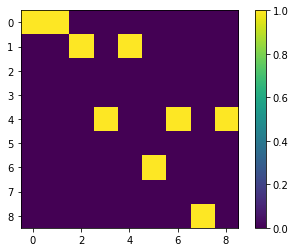

In [99]:
model = train()

In [ ]:
torch.save(model.state_dict(), "./content/drive/MyDrive/Dependency_Parsing/UD_English-Atis/dependency_parser_model.pt")

Plot the train loss

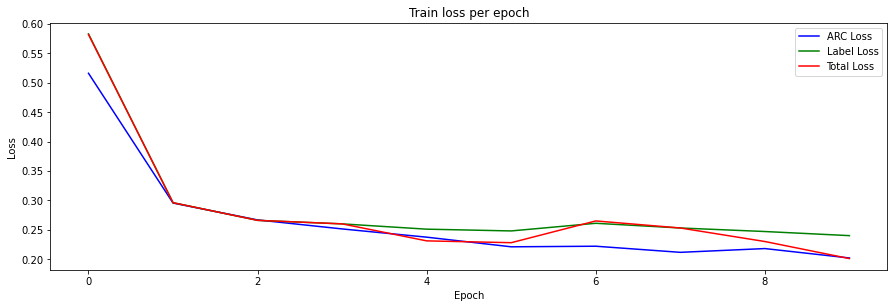

In [113]:
    fig1 =  plt.figure(figsize=(15, 10))
    plt.clf()
    plt.ylim(0,5)
    plt.subplot(211)
    plt.title("Train loss per epoch")
    plt.plot(model.arc_loss, 'b-')
    plt.plot(model.label_loss, 'g-')
    plt.plot(model.total_loss, 'r-')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['ARC Loss', 'Label Loss', 'Total Loss'], loc='upper right')
    plt.show()    
    fig1.savefig("Dependency_parsing_train_loss.png")


In [ ]:
N_EPOCH=1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Epoch: 0
ARC loss is : 0.5360124262814779
Label loss is : 0.5990030046228376
Total loss is : 0.5990030046228376
Epoch: 0


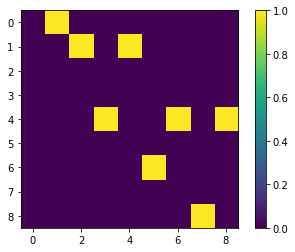

Epoch: 1
ARC loss is : 0.35139434518363216
Label loss is : 0.36354481414938455
Total loss is : 0.36354481414938455


In [111]:
model = train()


Evaluating the Model on Test set

In [132]:
def create_test_data(trainfile, testfile, label_file):
  train_data = json.load(open(trainfile, 'r'))
  words = {}

  #count occurences
  for s in train_data:
    for w in s['words']:
      oc = w.get(w['form'])
      if oc is None:
        words[w['form']] = 1
      else:
        words[w['form']] = oc + 1
  
  multi_words = []
  for w in words.keys():
    if words[w] > 1:
      multi_words.append(w)
  
  test_data = json.load(open(testfile, 'r'))

  #create new data
  for s in test_data:
    for w in s['words']:
      if w['form'] not in multi_words:
        w['form'] = '<unk>'
  
  labels_in_trainset = json.load(open(label_file, 'r'))

  test_data_with_existing_labels = []

  for obj in test_data:
    ad = True
    for w in obj['words']:
      if w['form'] == "Administrator":
        add = False
        break
      if w['deprel'] not in labels_in_trainset.keys():
        add = False
        break
    if ad:
      test_data_with_existing_labels.append(obj)
  
  with open(test_data_processed_file_path, 'w+') as f_handle:
    f_handle.write(json.dumps(test_data_with_existing_labels, indent=4))



In [139]:
def evaluate(model, test_data):
  #initialize word embeds
  word_embed_len = 100
  pos_embed_len = 20

  #fetch word and pos embeddings
  word_to_idx, pos_to_idx, lab_to_idx, pretrained_word_embedding, pretrained_pos_embedding = pretrain_word_embedding(test_data, word_embed_len, pos_embed_len)
  criterion = nn.CrossEntropyLoss()
  model.eval()
  arc_losses = []
  label_losses = []
  total_losses = []

  for i in range(len(test_data)):

      #fetch the length of each sequence
      seq_len = len(test_data[i]['words'])

      #create the adj matrix and tree
      gold_mat = convert_seq_to_mat(test_data[i])
      gold_tree = adj_mat_to_tensor(gold_mat)

      arc_target = Variable(gold_tree, requires_grad=False)
      labels_target = torch.LongTensor(seq_len)

      for j, w in enumerate(test_data[i]['words']):
        labels_target[j] = lab_to_idx[w['deprel']]
      labels_target = Variable(labels_target, requires_grad=False)

      # prepare input
      seq = torch.LongTensor(seq_len, 3)
      for j, w in enumerate(test_data[i]['words']):
        seq[j,0] = model.word_to_idx[w['form']]
        seq[j,1] = model.pos_to_idx[w['xpostag']]
        seq[j,2] = gold_tree[j]
      seq_var = Variable(seq)

      #run the model
      adj_mat, label_pred = model(seq_var)

      #determine losses
      arc_pred = torch.t(adj_mat) #cross entropy loss wants the classes in the second dimension
      arc_loss = criterion(arc_pred, arc_target)
      label_loss = criterion(label_pred, labels_target)
      total_loss = arc_loss + label_loss
      arc_losses.append(arc_loss.item())
      label_losses.append(label_loss.item())
      total_losses.append(total_loss.item())
    
  arc_loss = np.mean(arc_losses)
  label_loss = np.mean(label_losses)
  total_loss = np.mean(total_losses)

  print("ARC Loss on test data : "+ str(arc_loss))
  print("Label Loss on test data : "+ str(label_loss))
  print("Total Loss on test data : "+ str(total_loss))

In [140]:
create_test_data(train_data_processed_file_path, test_data_file_path, labels_file_path)
test_data = json.load(open(test_data_processed_file_path, 'r'))
evaluate(model, test_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:65: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


ARC Loss on test data : 1.618151715336805
Label Loss on test data : 1.257703941582413
Total Loss on test data : 2.8758556587500785


FIN!!